# Human Activity Recognition using TSFEL

On this notebook we will perform Human Activity Recognition using the **Time Series Feature Extraction Library**.

In [ ]:
!pip install tsfel

In [3]:
import tsfel

import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

# Dataset

The dataset we will be using is open-source. It is provided by UCI and it contains recordings of 30 subjects performing 6 activities of daily living while carrying a waist-mounted smartphone with embedded inertial sensors (sampling frequency = 50Hz). Each activity is associated with a label, as follows:

1. WALKING
2. WALKING_UPSTAIRS
3. WALKING_DOWNSTAIRS
4. SITTING
5. STANDING
6. LAYING

The dataset can be found [here](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones).

In [ ]:
fs = 50
activity_labels = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING']
X_train_sig, y_train, X_test_sig, y_test = tsfel.datasets.load_ucihar(use_cache=False)

As an example, let's take a look at some accelerometer signals (x axis) from the training set.

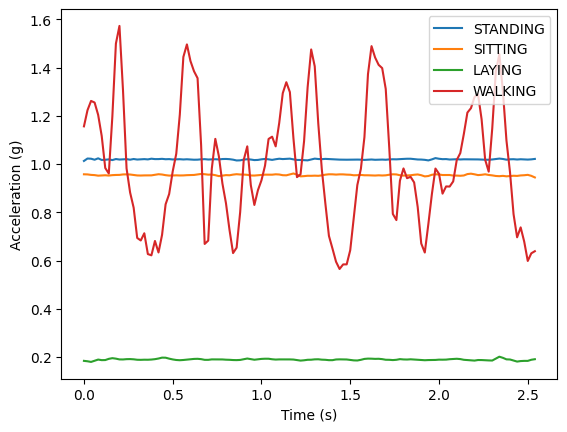

In [7]:
%matplotlib inline
plt.figure()
for i in [0, 50, 60, 90]:
    plt.plot(np.arange(0, X_train_sig[i].shape[0] / fs, 1 / fs), X_train_sig[i]['total_acc_x_'], label=activity_labels[int(y_train[i]) - 1])
plt.xlabel("Time (s)")
plt.ylabel("Acceleration (g)")
plt.legend()
plt.show()

# Feature Extraction

Through **Feature Extraction** methodologies, the data is translated into a feature vector containing information about the signal properties of each window. This features will be used as input to the machine learning classifier, and therefore the chosen set of features can strongly influence the classification output.

In [6]:
# @title Feature Extraction
cfg = tsfel.get_features_by_domain()  # Statistical, temporal and spectral features
# cfg = tsfel.get_features_by_domain('statistical') # Only statistical features
# cfg = tsfel.get_features_by_domain('temporal')    # Only temporal features
# cfg = tsfel.get_features_by_domain('spectral')    # Only spectral features

# Get features
X_train = tsfel.time_series_features_extractor(cfg, X_train_sig, fs=fs)
X_test = tsfel.time_series_features_extractor(cfg, X_test_sig, fs=fs)

# Feature Selection

After the sensor data is extracted, redundancies and noise should be removed. Thus, minimising the algorithm's error, time and computational complexity. 

In [8]:
# Highly correlated features are removed
corr_features, X_train = tsfel.correlated_features(X_train, drop_correlated=True)
X_test.drop(corr_features, axis=1, inplace=True)

# Remove low variance features
selector = VarianceThreshold()
X_train = selector.fit_transform(X_train)
X_test = selector.transform(X_test)

# Normalising Features
scaler = preprocessing.StandardScaler()
nX_train = scaler.fit_transform(X_train)
nX_test = scaler.transform(X_test)

# Classification

In this example the classification is performed with a [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) classifier.

In [9]:
clf = RandomForestClassifier()
clf.fit(nX_train, y_train)

# Predict test data
y_pred = clf.predict(nX_test)

# Get the classification report
accuracy = accuracy_score(y_test, y_pred) * 100
print(classification_report(y_test, y_pred, target_names=activity_labels))
print(f"Accuracy: {round(accuracy, 2)} %")

                    precision    recall  f1-score   support

           WALKING       0.95      0.98      0.97       496
  WALKING_UPSTAIRS       0.93      0.99      0.96       471
WALKING_DOWNSTAIRS       0.96      0.87      0.91       420
           SITTING       0.95      0.92      0.93       491
          STANDING       0.93      0.95      0.94       532
            LAYING       1.00      1.00      1.00       537

          accuracy                           0.95      2947
         macro avg       0.95      0.95      0.95      2947
      weighted avg       0.95      0.95      0.95      2947

Accuracy: 95.39 %


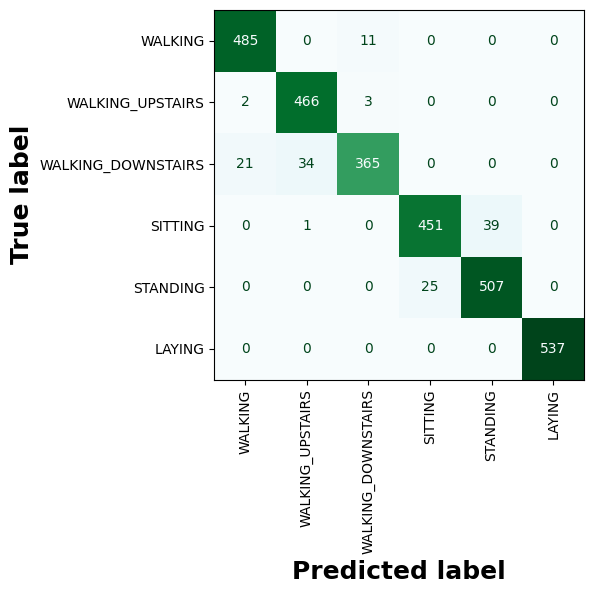

In [13]:
%matplotlib inline
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, xticks_rotation="vertical", display_labels=activity_labels, cmap="BuGn", values_format="d", colorbar=False) #annot=True,)
plt.ylabel("True label", fontweight="bold", fontsize=18)
plt.xlabel("Predicted label", fontweight="bold", fontsize=18)
plt.show()

# Conclusion

The confusion matrix shows some misclassification between the activities "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS" and "WALKING", as well as between "SITTING" and "STANDING". However, dynamic activities were clearly discriminated against static activities, as the features capture their distinct motion characteristics and cyclic behaviour.